# Match DMRs to featureCounts matrix

In [1]:
# import DMR dataframes from txt file 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# read in DMR data
dmrNA = pd.read_csv('/home/maggy/WholeGenomeBisulphiteSequencing/DNAseq_pipeline/7_match_dmr_to_gene/NvsA_gene_ids.txt', sep='\t', header=None)
dmrNR = pd.read_csv('/home/maggy/WholeGenomeBisulphiteSequencing/DNAseq_pipeline/7_match_dmr_to_gene/NvsR_gene_ids.txt', sep='\t', header=None)
dmrAR = pd.read_csv('/home/maggy/WholeGenomeBisulphiteSequencing/DNAseq_pipeline/7_match_dmr_to_gene/AvsR_gene_ids.txt', sep='\t', header=None)

In [2]:
# import fetaure cpounts (gene expression data)
expression = pd.read_csv('/home/maggy/WholeGenomeBisulphiteSequencing/RNAseq_pipeline/9_create_GeneCountsMatrix/gene_matrix_count.csv', sep=',', index_col=0)

In [3]:
# convert df to list for all DMR dataframes
dmrna = dmrNA[0].to_list()
dmrnr = dmrNR[0].to_list()
dmrar = dmrAR[0].to_list()
dmr = dmrna + dmrnr + dmrar

In [4]:
# filter expression df for all the DMR genes
expressiondmr = expression[expression.index.isin(dmr)]

In [5]:
# filter the rows that have as a sum less than 50 counts
expressiondmr = expressiondmr[(expressiondmr.sum(axis=1) >= 50)]

In [6]:
# reorder the columns of the expression dataframes
# Specify the desired column order
column_order = ['N1', 'N2', 'N3', 'N7', 'A1', 'A2', 'A4', 'A7', 'R2', 'R3', 'R7', 'R8']
# Reorder the dataframe columns
expressiondmr = expressiondmr.reindex(columns=column_order)

In [7]:
expressiondmr.isna().any().any()

False

# z scaling 

In [8]:
# Calculate the mean and standard deviation for each gene across samples
mean = expressiondmr.mean(axis=1)
std_dev = expressiondmr.std(axis=1)

# Perform Z scaling on the data
expressiondmr = (expressiondmr.sub(mean, axis=0)).div(std_dev, axis=0)


In [9]:
# split the expressiondmr df into three df 
expressionNA = expressiondmr[expressiondmr.index.isin(dmrna)]
expressionNR = expressiondmr[expressiondmr.index.isin(dmrnr)]
expressionAR = expressiondmr[expressiondmr.index.isin(dmrar)]

# Plot

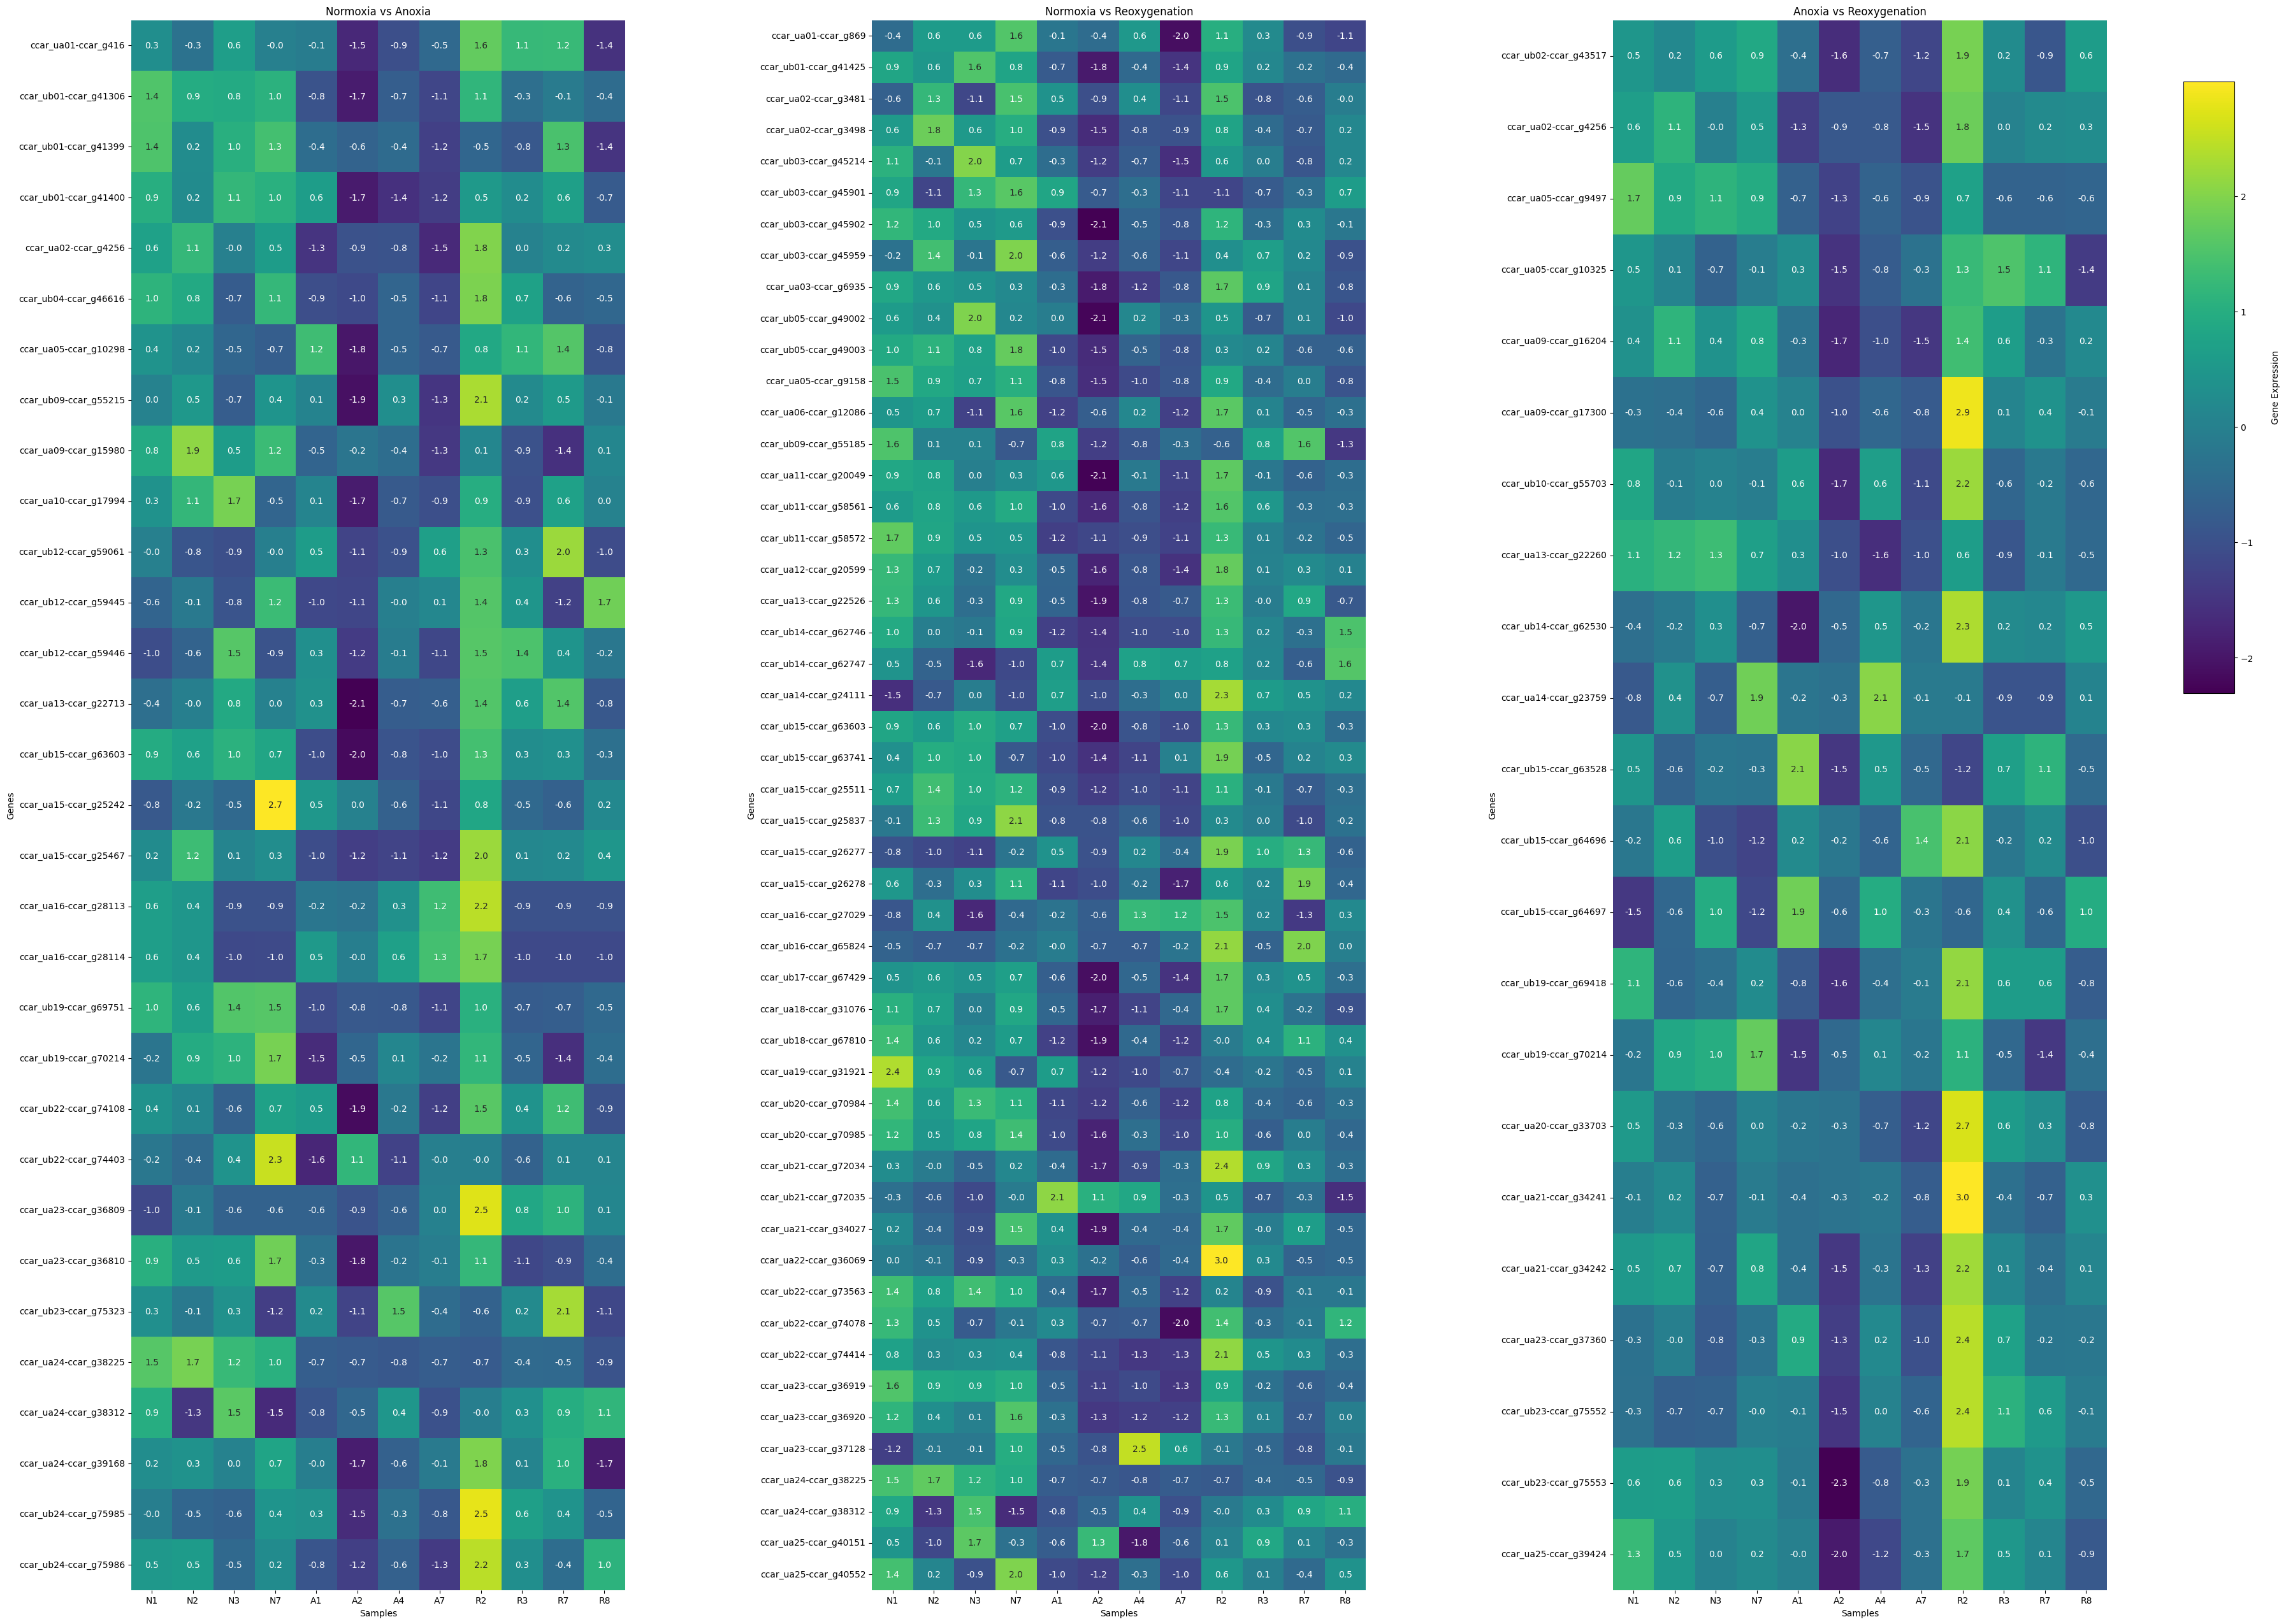

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# create a plot with 3 subplots 
fig, axs = plt.subplots(1, 3, figsize=(40, 32), gridspec_kw={'wspace': 0.5})

# plot the heatmap for Normoxia vs Anoxia
sns.heatmap(expressionNA, ax=axs[0], cmap='viridis', cbar=False, annot=True, fmt=".1f")
axs[0].set_title('Normoxia vs Anoxia')
axs[0].set_xlabel('Samples')
axs[0].set_ylabel('Genes')

# plot the heatmap for Normoxia vs Reoxygenation
sns.heatmap(expressionNR, ax=axs[1], cmap='viridis', cbar=False, annot=True, fmt=".1f")
axs[1].set_title('Normoxia vs Reoxygenation')
axs[1].set_xlabel('Samples')
axs[1].set_ylabel('Genes')

# plot the heatmap for Anoxia vs Reoxygenation
sns.heatmap(expressionAR, ax=axs[2], cmap='viridis', cbar=False, annot=True, fmt=".1f")
axs[2].set_title('Anoxia vs Reoxygenation')
axs[2].set_xlabel('Samples')
axs[2].set_ylabel('Genes')

# Add a single color bar on the right side with smaller scale
cbar_ax = fig.add_axes([0.93, 0.55, 0.02, 0.3])  # [left, bottom, width, height]
cb = fig.colorbar(axs[2].collections[0], cax=cbar_ax)  
cb.set_label('Gene Expression', labelpad=20, size=10)
plt.show()
